In [1]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
df = pd.read_csv('salary_prediction_data.csv')

df['Education'] = df['Education'].map({'PhD': 3, 'Master': 2, 'Bachelor': 1, 'High School': 0})
df['Location'] = df['Location'].map({'Urban': 2, 'Suburban': 1, 'Rural': 0})
df['Job_Title'] = df['Job_Title'].map({'Manager': 3, 'Director': 2, 'Analyst': 1, 'Engineer': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}) 

print(df.head())

   Education  Experience  Location  Job_Title  Age  Gender         Salary
0          0           8         2          3   63       1   84620.053665
1          3          11         1          2   59       1  142591.255894
2          1          28         1          3   61       0   97800.255404
3          0          29         0          2   45       1   96834.671282
4          3          25         2          1   26       0  132157.786175


In [3]:
X = df[['Education','Experience','Location','Job_Title','Age','Gender']].values
Y = df[['Salary']].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [4]:
X_train = X_train.astype(float)
Y_train = Y_train.astype(float)
X_val = X_val.astype(float)
Y_val = Y_val.astype(float)

In [5]:
from sklearn.svm import SVR
SVR_model =SVR(kernel='rbf',C=100000000,gamma= 0.001)
SVR_model.fit(X_train,Y_train)


c:\Users\ben00\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100000000, gamma=0.001)

In [6]:
KRG_model = KRG(theta0=[1e-2], corr='squar_exp')
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 800
   
___________________________________________________________________________
   
 Training
   
   Training ...


c:\Users\ben00\AppData\Local\Programs\Python\Python311\Lib\site-packages\smt\surrogate_models\krg_based.py:462: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn(


   Training - done. Time (sec): 49.0543370


In [34]:
RBF_model = RBF(d0=500)
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 800
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (800 x 800 mtx) ...
         Performing LU fact. (800 x 800 mtx) - done. Time (sec):  0.0149589
      Initializing linear solver - done. Time (sec):  0.0149589
      Solving linear system (col. 0) ...
         Back solving (800 x 800 mtx) ...
         Back solving (800 x 800 mtx) - done. Time (sec):  0.0010052
      Solving linear system (col. 0) - done. Time (sec):  0.0010052
   Training - done. Time (sec):  0.3221383


In [8]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

#   5. Evaluate the model
Y_predicted_ANN = model.predict(X_val)
print("MSE, for ANN", mean_squared_error(Y_val, Y_predicted_ANN))


Epoch 1/500
25/25 [==============================] - 2s 20ms/step - loss: 11882040320.0000 - val_loss: 12169778176.0000
Epoch 2/500
25/25 [==============================] - 0s 19ms/step - loss: 11869218816.0000 - val_loss: 12126154752.0000
Epoch 3/500
25/25 [==============================] - 0s 6ms/step - loss: 11669771264.0000 - val_loss: 11599502336.0000
Epoch 4/500
25/25 [==============================] - 0s 8ms/step - loss: 10182317056.0000 - val_loss: 8529744384.0000
Epoch 5/500
25/25 [==============================] - 0s 6ms/step - loss: 4933448704.0000 - val_loss: 1493677824.0000
Epoch 6/500
25/25 [==============================] - 0s 7ms/step - loss: 709078144.0000 - val_loss: 497360352.0000
Epoch 7/500
25/25 [==============================] - 0s 7ms/step - loss: 510969600.0000 - val_loss: 472519360.0000
Epoch 8/500
25/25 [==============================] - 0s 6ms/step - loss: 451057472.0000 - val_loss: 414262464.0000
Epoch 9/500
25/25 [==============================] - 0s 12ms/

In [35]:
X_new = np.array([['2','3','2','0','24','1']])
Y_predicted_KRG = KRG_model.predict_values(X_val)
print("MSE, for KRG:", mean_squared_error(Y_val, Y_predicted_KRG))
Y_predicted_RBF = RBF_model.predict_values(X_val)
print("MSE, for RBF:", mean_squared_error(Y_val, Y_predicted_RBF))
Y_predicted_SVR = SVR_model.predict(X_val)


___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.5919871
   
   Prediction time/pt. (sec) :  0.0029599
   
MSE, for KRG: 235654249.66701263
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.0442469
   
   Prediction time/pt. (sec) :  0.0002212
   
MSE, for RBF: 165448078.07264093


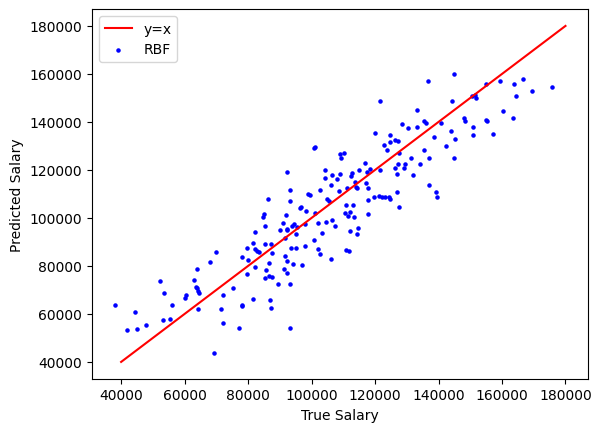

In [36]:
plt.plot([40000, 180000], [40000, 180000], label='y=x', color='red')
#plt.scatter(Y_val,Y_predicted_SVR, s=5, label= 'SVR', color='red')
#plt.scatter(Y_val, Y_predicted_KRG, s=5, label='KRG', color='green')
#plt.scatter(Y_val, Y_predicted_ANN, s=5, label='ANN', color='orange')

plt.scatter(Y_val, Y_predicted_RBF, s=5, label='RBF', color='blue')
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.legend()




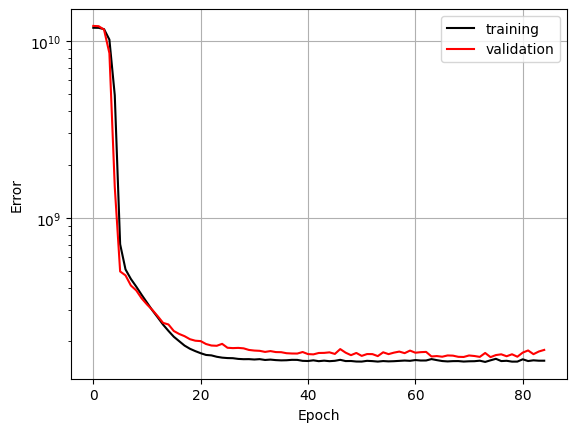

In [11]:
plt.semilogy(history.history['loss'],'k',label='training')
plt.semilogy(history.history['val_loss'],'r',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()